In [2]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import itertools
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.patches as patches
from scipy.stats.stats import pearsonr
from matplotlib import gridspec
%matplotlib inline

font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'

In [3]:
blacklist_genes = ['RSPO1','LMX1A','FOXJ1','DBX1','EN2']
#blacklist_genes = ['EN2','DBX1','DMBX1','PEG3','ZBTB18']
reg_and_temp_genes = {}
with open('/mnt/e/MPIMG/Rotation/elkabetz/elkabetz_data/scRNA_regional_and_temporal_genes.txt','r') as reg_and_temp_genes_fn:
    for i,row in enumerate(reg_and_temp_genes_fn):
        spl = row.strip("\r\n").split("\t")
        if i == 0: 
            print spl
            continue
        if spl[0] in blacklist_genes: continue
        if spl[-1] not in reg_and_temp_genes:
            reg_and_temp_genes[spl[-1]] = []
        #if spl[1] not in ['Neural Stem Cells','Diencephalon','Midbrain/Hindbrain']: continue
        reg_and_temp_genes[spl[-1]].append((spl[0],spl[1]))

['gene', 'cell_type', 'type']


In [4]:
sbn_color='purple'
sbnx_color='yellow'
nt_color='green'
#sbn_color=(153/256.,0.,0.)
#sbnx_color=(255/256.,128/256.,0.)
#nt_color=(255/256.,255/256.,0)
color_dict = {'sbn':sbn_color,'sbnx':sbnx_color,'nt':nt_color}

In [5]:
## load in data

sc_dat_dir = '/mnt/e/MPIMG/Rotation/elkabetz/scrna/Brain/counts_elk/'
single_cell_data = {}
for fn in os.listdir(sc_dat_dir):
    print fn
    df = pd.read_csv(sc_dat_dir+fn,sep=',')
    df = df.set_index(df['Unnamed: 0'])
    df = df.drop('Unnamed: 0',axis=1)
    #mt_genes = [x for x in df.index if 'MT.' in x]
    #df = df.drop(mt_genes,axis=0)
    single_cell_data[fn.split(".")[0]] = df
    
single_cell_data_norm_rpm = {}
single_cell_data_norm_rpm_logged = {}
add_diff = 1.0
for clust in single_cell_data:
    
    print clust
    sc_dat = single_cell_data[clust]
    cols = sc_dat
    sc_dat_backup = copy.deepcopy(sc_dat)
    sc_dat = copy.deepcopy(sc_dat_backup)
    
    ## gives you RPM
    sc_dat.loc[-1]  = sc_dat.sum()/10000.
    sc_dat = sc_dat.div(sc_dat.loc[-1],axis=1)
    sc_dat = sc_dat.drop([-1])
    single_cell_data_norm_rpm[clust] = sc_dat
    single_cell_data_norm_rpm_logged[clust] = np.log(sc_dat+1.)/np.log(2)
    
full_df_rpm_logged = {}
full_df_counts = {}
for clust in single_cell_data_norm_rpm_logged:
    if 'SBNG' in clust:
        if 'SBN' not in full_df_rpm_logged:
            full_df_rpm_logged['SBN'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['SBN'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['SBN'] = pd.concat([full_df_rpm_logged['SBN'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['SBN'] = pd.concat([full_df_counts['SBN'],single_cell_data[clust]],axis=1)
    if 'SBNx' in clust:
        if 'SBNx' not in full_df_rpm_logged:
            full_df_rpm_logged['SBNx'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['SBNx'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['SBNx'] = pd.concat([full_df_rpm_logged['SBNx'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['SBNx'] = pd.concat([full_df_counts['SBNx'],single_cell_data[clust]],axis=1)
    if 'NT' in clust:
        if 'NT' not in full_df_rpm_logged:
            full_df_rpm_logged['NT'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['NT'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['NT'] = pd.concat([full_df_rpm_logged['NT'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['NT'] = pd.concat([full_df_counts['NT'],single_cell_data[clust]],axis=1)
    if 'XG' in clust:
        if 'X' not in full_df_rpm_logged:
            full_df_rpm_logged['X'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['X'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['X'] = pd.concat([full_df_rpm_logged['X'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['X'] = pd.concat([full_df_counts['X'],single_cell_data[clust]],axis=1)
            
for i,tx in enumerate(full_df_counts.keys()):
    tmp_df=copy.deepcopy(full_df_counts[tx])
    tmp_df[-1] = tmp_df.sum(axis=1)
    tmp_df=tmp_df.drop([x for x in tmp_df.columns if x != -1],axis=1)
    tmp_df=tmp_df.rename(index=str, columns={-1: tx})
    if i == 0:
        merged_counts_df = copy.deepcopy(tmp_df)
    else:
        merged_counts_df = pd.concat([merged_counts_df,tmp_df],axis=1)

merged_counts_df = merged_counts_df.fillna(0)
sc_dat = copy.deepcopy(merged_counts_df)
sc_dat.loc[-1]  = sc_dat.sum()/10000.
sc_dat = sc_dat.div(sc_dat.loc[-1],axis=1)
sc_dat = sc_dat.drop([-1])
merged_counts_df_rpm_logged = np.log(sc_dat+1.)/np.log(2)

for i,tx in enumerate(full_df_rpm_logged.keys()):
    tmp_df=copy.deepcopy(full_df_rpm_logged[tx])
    tmp_df[-1] = tmp_df.mean(axis=1)
    tmp_df=tmp_df.drop([x for x in tmp_df.columns if x != -1],axis=1)
    tmp_df=tmp_df.rename(index=str, columns={-1: tx})
    if i == 0:
        avg_logged_rpm_df = copy.deepcopy(tmp_df)
    else:
        avg_logged_rpm_df = pd.concat([avg_logged_rpm_df,tmp_df],axis=1)
avg_logged_rpm_df = avg_logged_rpm_df.fillna(0)

NTG1.csv
NTG2.csv
NTG3.csv
NTG4.csv
NTG5.csv
NTG6.csv
NTG7.csv
NTG8.csv
NTG9.csv
SBNG1.csv
SBNG10.csv
SBNG11.csv
SBNG2.csv
SBNG3.csv
SBNG4.csv
SBNG5.csv
SBNG6.csv
SBNG7.csv
SBNG8.csv
SBNG9.csv
SBNxG1.csv
SBNxG10.csv
SBNxG2.csv
SBNxG3.csv
SBNxG4.csv
SBNxG5.csv
SBNxG6.csv
SBNxG7.csv
SBNxG8.csv
SBNxG9.csv
XG1.csv
XG2.csv
XG3.csv
XG4.csv
XG5.csv
XG6.csv
XG7.csv
XG8.csv
XG9.csv
NTG3
NTG2
NTG1
SBNxG5
NTG7
NTG6
NTG5
NTG4
NTG9
NTG8
XG8
XG9
XG6
XG7
XG4
XG5
XG2
XG3
XG1
SBNxG10
SBNG9
SBNG8
SBNG3
SBNG2
SBNG1
SBNG7
SBNG6
SBNG5
SBNG4
SBNxG8
SBNxG9
SBNxG6
SBNxG7
SBNG11
SBNG10
SBNxG2
SBNxG3
SBNxG1
SBNxG4


In [8]:
full_df_rpm = {}
full_df_rpm['SBNx'] = np.exp(full_df_rpm_logged['SBNx'])-1
full_df_rpm['SBN'] = np.exp(full_df_rpm_logged['SBN'])-1
full_df_rpm['NT'] = np.exp(full_df_rpm_logged['NT'])-1
full_df_rpm['X'] = np.exp(full_df_rpm_logged['X'])-1

In [9]:
def make_heatmap_zscore(fig,ax,genes_grouped,clusters_df,ordered_clusters,df_clust,clust_col='res.0.8',breaks=[],labs=None):
    
    colormap = cm.bwr
    normed_cmap = Normalize(vmin=-1.5, vmax=1.5)
    ax.yaxis.set_ticks_position('both')
    
    ## calculate zscores per gene per cluster (list ordered by ordered_clusters)
    zscores_per_gene = {}
    for gene,group in genes_grouped:
        if gene in clusters_df[ordered_clusters].index:
            log_expr_vals_arr = np.array(clusters_df[ordered_clusters].loc[gene].values)
            mean_vals = np.mean(log_expr_vals_arr)
            std_dev = np.std(log_expr_vals_arr)
            zscores_per_gene[gene] = (log_expr_vals_arr-mean_vals)/std_dev
        else:
            zscores_per_gene[gene] = np.array([-2]*len(ordered_clusters))
    
    prev_group = genes_grouped[0][1]
    buff = 0
    xbuff = 0
    yticks = []
    region_ticks = []
    region_labs = []
    grp_cnt = 0
    xticks = []
    for j,(gene,group) in enumerate(genes_grouped):
        if group != prev_group: 
            #plt.axhline(-j-buff+0.5,color='black',linewidth=1)
            #plt.axhline(-j-buff-0.5,color='black',linewidth=1)
            region_ticks.append(-j-buff+(grp_cnt+1)/2.)
            region_labs.append(prev_group)
            buff += 1
            grp_cnt = 0
            prev_group = group
        grp_cnt += 1
        xbuff = 0
        for k,clust in enumerate(ordered_clusters):
            val = zscores_per_gene[gene][k]
            color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
            p = patches.Rectangle((k+xbuff-1/2.,-j-1/2.-buff), 1, 1, fill=True, 
                                  facecolor=color, linestyle='-',edgecolor=color)
            ax.add_patch(p)
            xticks.append(j+xbuff)
            if k in breaks:
                xbuff += 1
        yticks.append(-j-buff)
    buff+=1
    region_ticks.append(-j-buff+(grp_cnt+1)/2.)
    region_labs.append(prev_group)
    plt.yticks(yticks,[x[0] for x in genes_grouped])
    xticks = []
    xbuff = 0
    for x in range(len(ordered_clusters)):
        xticks.append(x+xbuff)
        if x in breaks:
            xbuff+=1
    if labs is None:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=16)
    else:
        plt.xticks(xticks,[str(x) for x in labs],fontsize=16)
    plt.xlim(-0.5,k+0.5+xbuff)
    plt.ylim(-j+0.5-buff,0.5)
    ax.yaxis.set_ticks_position("left")
    ax2 = ax.twinx()
    plt.yticks(region_ticks,region_labs,fontsize=14)
    plt.ylim(-j+0.5-buff,0.5)
    ax2.yaxis.set_ticks_position("left")
    ax.yaxis.set_ticks_position("right")
    return fig

def make_heatmap_vals(fig,ax,genes_grouped,clusters_df,ordered_clusters,df_clust,clust_col='res.0.8'):
    
    colormap = cm.GnBu
    normed_cmap = Normalize(vmin=0, vmax=1)
    ax.yaxis.set_ticks_position('both')
    
    prev_group = genes_grouped[0][1]
    buff = 0
    yticks = []
    region_ticks = []
    region_labs = []
    grp_cnt = 0
    for j,(gene,group) in enumerate(genes_grouped):
        if group != prev_group: 
            plt.axhline(-j-buff+0.5,color='black',linewidth=1)
            plt.axhline(-j-buff-0.5,color='black',linewidth=1)
            region_ticks.append(-j-buff+(grp_cnt+1)/2.)
            region_labs.append(prev_group)
            buff += 1
            grp_cnt = 0
            prev_group = group
        grp_cnt += 1
        for k,clust in enumerate(ordered_clusters):
            val = clusters_df[clust].loc[gene]
            color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
            p = patches.Rectangle((k-1/2.,-j-1/2.-buff), 1, 1, fill=True, 
                                  facecolor=color, linestyle='-',edgecolor=color)
            ax.add_patch(p)
        yticks.append(-j-buff)
    region_ticks.append(-j-buff+(grp_cnt+1)/2.)
    region_labs.append(prev_group)
    plt.yticks(yticks,[x[0] for x in genes_grouped])
    plt.xticks(range(len(ordered_clusters)),['C'+str(x+1) for x in ordered_clusters])
    plt.xlim(-0.5,k+0.5)
    plt.ylim(-j-0.5-buff,0.5)
    ax.yaxis.set_ticks_position("left")
    ax2 = ax.twinx()
    plt.yticks(region_ticks,region_labs,fontsize=14)
    plt.ylim(-j-0.5-buff,0.5)
    ax2.yaxis.set_ticks_position("left")
    ax.yaxis.set_ticks_position("right")
    return fig

In [10]:
def add_picharts(fig,y_start,y_end,ordered_clusters,n_cells_per_clust,color_dict,breaks=[]):
    xbuff=0
    for j,clust in enumerate(ordered_clusters):
        ax = plt.subplot(gs[y_start:y_end,j+xbuff])
        sizes = [n_cells_per_clust[clust][x] for x in ['sbnx','sbn','nt']]
        colors = [color_dict[x] for x in ['sbnx','sbn','nt']]
        explode = (0, 0, 0)
        plt.pie(sizes, explode=explode,colors=colors,startangle=0)
        plt.axis('off')
        plt.tight_layout()
        plt.axis('square')
        if j in breaks:
            xbuff += 1
    return fig

def add_bars(fig,y_start,y_end,ordered_clusters,n_cells_per_clust,color_dict,breaks = []):
    max_num = max([sum(n_cells_per_clust[clust].values()) for clust in ordered_clusters])
    xbuff=0
    for j,clust in enumerate(ordered_clusters):
        ax = plt.subplot(gs[y_start:y_end,j+xbuff])
        plt.bar(0,sum(n_cells_per_clust[clust].values()),width=1,color='gray')
        if j == 0:
            ax.set_frame_on(False)
            ax.get_xaxis().set_visible(False)
            #plt.yticks([0,500,1000],fontsize=8)
            plt.yticks([])
            plt.ylabel('No. cells',fontsize=14)
        else:
            plt.axis('off')
        rects = ax.patches
        labels = [sum(n_cells_per_clust[clust].values())]
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., height + 0.05*rect.get_height(), label,
                    ha='center', va='bottom')
        plt.xlim(-1,1)
        plt.ylim(0,max_num+0.1*max_num)
        if j in breaks:
            xbuff += 1
    return fig

In [11]:
df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/metadata.sbnx_sbn_nt.csv',sep=',')
df_sbnx_sbn_clust = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/tsne.sbnx_sbn_nt.csv',sep=',')
df.columns=['cell','tSNE_1','tSNE_2']
df_sbnx_sbn_tsne = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/pca.sbnx_sbn_nt.csv',sep=',')
cols = list(df.columns)
cols[0] = 'cell'
df.columns = cols
df_sbnx_sbn_pca = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/markers.sbnx_sbn_nt.csv',sep=',')
df_markers = copy.deepcopy(df)

In [12]:
clust_col='res.0.6'
ordered_clusters = range(len(set(df_sbnx_sbn_clust[clust_col])))

In [13]:
print 'num sbnx cells:', len([x for x in df_sbnx_sbn_pca['cell'] if 'sbnx.' in x])
print 'num sbn cells:', len([x for x in df_sbnx_sbn_pca['cell'] if 'sbn.' in x])
print 'num nt cells:', len([x for x in df_sbnx_sbn_pca['cell'] if 'nt.' in x])
num_sbnx_cells = float(len([x for x in df_sbnx_sbn_pca['cell'] if 'sbnx.' in x]))
num_sbn_cells = float(len([x for x in df_sbnx_sbn_pca['cell'] if 'sbn.' in x]))
num_nt_cells = float(len([x for x in df_sbnx_sbn_pca['cell'] if 'nt.' in x]))

num sbnx cells: 3291
num sbn cells: 2878
num nt cells: 2809


In [15]:
for cortical_clust in [1,7,5,3,0,9,4]:
    cells = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col] == cortical_clust]['Unnamed: 0']
    sbnx_cells = [x for x in cells if x.split(".")[0] == 'sbnx']
    sbn_cells = [x for x in cells if x.split(".")[0] == 'sbn']
    nt_cells = [x for x in cells if x.split(".")[0] == 'nt']
    print cortical_clust, 'sbnx:', len(sbnx_cells)/num_sbnx_cells, 'sbn:', len(sbn_cells)/num_sbn_cells, 'nt:', len(nt_cells)/num_nt_cells

1 sbnx: 0.210878152537 sbn: 0.173731758165 nt: 0.00961196155215
7 sbnx: 0.0853843816469 sbn: 0.0785267546908 nt: 0.0117479530082
5 sbnx: 0.209054998481 sbn: 0.0781792911744 nt: 0.0135279458882
3 sbnx: 0.176542084473 sbn: 0.149409312022 nt: 0.0060519757921
0 sbnx: 0.231540565178 sbn: 0.195621959694 nt: 0.00925596297615
9 sbnx: 0.0212701306594 sbn: 0.0705350938151 nt: 0.0331078675685
4 sbnx: 0.0583409298086 sbn: 0.234537873523 nt: 0.0327518689925


In [16]:
def read_in_gene_sets(regional_gene_fn):
    gene_sets = {}
    full_gene_list = []
    with open(regional_gene_fn,'r') as gene_sets_fn:
        for row in gene_sets_fn:
            spl = row.strip("\n").split("\t")
            if spl[1] not in gene_sets: gene_sets[spl[1]] = []
            gene_sets[spl[1]].append(spl[0])
            full_gene_list.append(spl[0])
    return gene_sets,full_gene_list

In [17]:
gene_sets,full_gene_list = read_in_gene_sets(regional_gene_fn='/mnt/e/MPIMG/Elkabetz/AllenBrainAtlas/regional_genes_joined_wk12_to_21.removed_AMY_STR.tsv')

In [18]:
full_df_rpm_logged['SBNx'].columns[full_df_rpm_logged['SBNx'].loc['HES5'] > 0]

Index([u'bcEERJ', u'bcIDTK', u'bcCFIJ', u'bcEMPC', u'bcESCW', u'bcFWVF',
       u'bcFYIX', u'bcARTE', u'bcDKOC', u'bcCWVZ',
       ...
       u'bcIGNO', u'bcGBZV', u'bcDWBW', u'bcHKIS', u'bcHFHB', u'bcCKLV',
       u'bcGBQR', u'bcHBWE', u'bcGJZS', u'bcCKMD'],
      dtype='object', length=169)

In [19]:
tx_sub_cells = {}
for tx in ['SBNx','NT','SBN']:
    sox2_sub_cells = full_df_rpm_logged[tx].columns[full_df_rpm_logged[tx].loc['SOX2'] > 0]
    hes5_sub_cells = full_df_rpm_logged[tx].columns[full_df_rpm_logged[tx].loc['HES5'] > 0]
    pax6_sub_cells = full_df_rpm_logged[tx].columns[full_df_rpm_logged[tx].loc['PAX6'] > 0]
    dcx_sub_cells = full_df_rpm_logged[tx].columns[full_df_rpm_logged[tx].loc['DCX'] > 0]
    full_sub = set(sox2_sub_cells).intersection(hes5_sub_cells)#.intersection(pax6_sub_cells)
    #full_sub = set(dcx_sub_cells)
    print tx, len(full_sub)
    tx_sub_cells[tx] = list(full_sub)

SBNx 100
NT 210
SBN 70


In [20]:
tx_log_rpm = {}
for tx in ['SBNx','SBN','NT']:
    summed_log_rpm = np.log(full_df_counts[tx][tx_sub_cells[tx]].sum(axis=1)/full_df_counts[tx][tx_sub_cells[tx]].sum(axis=1).sum()*10000+1)/np.log(2)
    tx_log_rpm[tx] = {}
    for xx in summed_log_rpm.items():
        tx_log_rpm[tx][xx[0]] = xx[1]

all_genes = set(tx_log_rpm['SBNx'].keys())
all_genes = all_genes.union(set(tx_log_rpm['SBN'].keys()))
all_genes = all_genes.union(set(tx_log_rpm['NT'].keys()))

for tx in tx_log_rpm:
    for gene in all_genes:
        if gene not in tx_log_rpm[tx]:
            tx_log_rpm[tx][gene] = 0

In [21]:
up_reg_sbnx_sbn = {}
for gene in tx_log_rpm['SBNx']:
    up_reg_sbnx_sbn[gene] = tx_log_rpm['SBNx'][gene] - tx_log_rpm['SBN'][gene]

In [25]:
for cortical_clust in [1,7,5,3,0,9,4]:
    cells = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col] == cortical_clust]['Unnamed: 0']
    sbnx_cells = [x for x in cells if x.split(".")[0] == 'sbnx']
    sbn_cells = [x for x in cells if x.split(".")[0] == 'sbn']
    nt_cells = [x for x in cells if x.split(".")[0] == 'nt']
    print cortical_clust, 'sbnx:', float(len(sbnx_cells))/len(cells), 'sbn:', float(len(sbn_cells))/len(cells), 'nt:', float(len(nt_cells))/len(cells)

1 sbnx: 0.568386568387 sbn: 0.4095004095 nt: 0.022113022113
7 sbnx: 0.52037037037 sbn: 0.418518518519 nt: 0.0611111111111
5 sbnx: 0.723449001052 sbn: 0.236593059937 nt: 0.0399579390116
3 sbnx: 0.565175097276 sbn: 0.418287937743 nt: 0.0165369649805
0 sbnx: 0.564026646928 sbn: 0.416728349371 nt: 0.019245003701
9 sbnx: 0.191256830601 sbn: 0.554644808743 nt: 0.254098360656
4 sbnx: 0.200208550574 sbn: 0.70385818561 nt: 0.0959332638165


In [26]:
cells = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col] == 9]['Unnamed: 0']
for j,tx in enumerate(['SBN']):
    if j == 0:
        df_sub = full_df_rpm_logged[tx][[x.split(".")[1] for x in [x for x in [tx.lower()+'.'+x for x in full_df_rpm_logged[tx].columns] if x in list(cells)]]]
        df_sub.columns=[x for x in [tx.lower()+'.'+x for x in full_df_rpm_logged[tx].columns] if x in list(cells)]
    else:
        cols_tmp=list(df_sub.columns)
        df_sub = pd.concat([df_sub,full_df_rpm_logged[tx][[x.split(".")[1] for x in [x for x in [tx.lower()+'.'+x for x in full_df_rpm_logged[tx].columns] if x in list(cells)]]]],axis=1)
        cols_tmp.extend([x for x in [tx.lower()+'.'+x for x in full_df_rpm_logged[tx].columns] if x in list(cells)])
        df_sub.columns = cols_tmp
df_sub = df_sub.fillna(0)

In [31]:
## recalculate log rpm values per cluster
cells_per_clust = {}
for clust in ordered_clusters:
    cells_per_clust[clust] = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col]==clust]['Unnamed: 0'].values

cluster_counts = copy.deepcopy(full_df_counts['SBNx'])
cluster_counts = cluster_counts.drop(cluster_counts.columns,axis=1)
cluster_counts_sep = copy.deepcopy(cluster_counts)
n_cells_per_clust = {}

for clust in ordered_clusters:
    
    cells_in_clust = cells_per_clust[clust]
    sbn_cells = [cell.split(".")[1] for cell in cells_in_clust if cell.split(".")[0]=='sbn']
    sbnx_cells = [cell.split(".")[1] for cell in cells_in_clust if cell.split(".")[0]=='sbnx']
    nt_cells = [cell.split(".")[1] for cell in cells_in_clust if cell.split(".")[0]=='nt']
    n_cells_per_clust[clust] = {'sbn':len(sbn_cells), 'sbnx':len(sbnx_cells), 'nt':len(nt_cells)}

    tmp_df = copy.deepcopy(full_df_counts['SBNx'][sbnx_cells])
    tmp_df = pd.concat([tmp_df,full_df_counts['SBN'][sbn_cells]],axis=1)
    tmp_df = pd.concat([tmp_df,full_df_counts['NT'][nt_cells]],axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df = tmp_df.sum(axis=1)
    
    sbnx_df=full_df_counts['SBNx'][sbnx_cells].sum(axis=1)
    sbn_df=full_df_counts['SBN'][sbn_cells].sum(axis=1)
    nt_df=full_df_counts['NT'][nt_cells].sum(axis=1)
    cluster_counts_sep = pd.concat([cluster_counts_sep,sbnx_df],axis=1)
    cluster_counts_sep = pd.concat([cluster_counts_sep,sbn_df],axis=1)
    cluster_counts_sep = pd.concat([cluster_counts_sep,nt_df],axis=1)
    cluster_counts_sep = cluster_counts_sep.fillna(0)
    
    cluster_counts = pd.concat([cluster_counts,tmp_df],axis=1)

cluster_counts_sep_columns = []
for clust in ordered_clusters:
    for tx in ['sbnx','sbn','nt']:
        cluster_counts_sep_columns.append(tx+'.'+str(clust))

cluster_counts_sep.columns = cluster_counts_sep_columns
cluster_counts.columns = ordered_clusters
cluster_counts_rpm_logged = copy.deepcopy(cluster_counts)
cluster_counts_rpm_logged.loc[-1]  = cluster_counts_rpm_logged.sum()/10000.
cluster_counts_rpm_logged = cluster_counts_rpm_logged.div(cluster_counts_rpm_logged.loc[-1],axis=1)
cluster_counts_rpm_logged = cluster_counts_rpm_logged.drop([-1])
cluster_counts_rpm = copy.deepcopy(cluster_counts_rpm_logged)
cluster_counts_rpm_logged = np.log(cluster_counts_rpm_logged+1.)

cluster_counts_sep_rpm_logged = copy.deepcopy(cluster_counts_sep)
cluster_counts_sep_rpm_logged.loc[-1]  = cluster_counts_sep_rpm_logged.sum()/10000.
cluster_counts_sep_rpm_logged = cluster_counts_sep_rpm_logged.div(cluster_counts_sep_rpm_logged.loc[-1],axis=1)
cluster_counts_sep_rpm_logged = cluster_counts_sep_rpm_logged.drop([-1])
cluster_counts_sep_rpm = copy.deepcopy(cluster_counts_sep_rpm_logged)
cluster_counts_sep_rpm_logged = np.log(cluster_counts_sep_rpm_logged+1.)


In [56]:
cluster_map = {1:1,7:2,5:5,3:3,0:4,9:6,4:7,10:12,11:11,8:8,2:9,6:10}
cluster_map_r = {}
for clust1,clust2 in cluster_map.items():
    cluster_map_r[clust2] = clust1

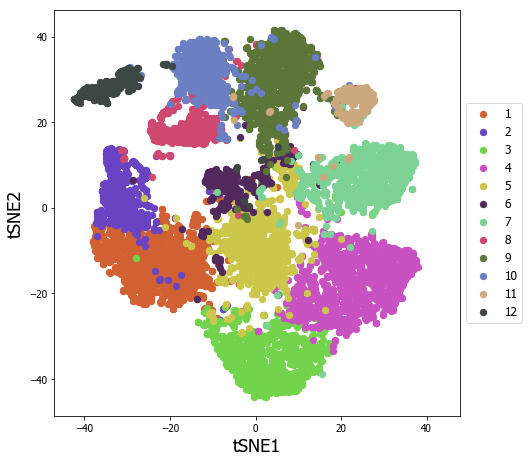

In [57]:
color_list=["#d16132","#6943c1","#73d34c","#c852c1","#ccc64b","#51295c","#7cd295","#ce486f","#5b7638",
            "#6b7fc2","#cca87f","#3d4744","#ca97bd","#793e33","#81bec2"]
fig = plt.figure(figsize=(20,20))
ax=plt.subplot(121)
markersize=40
alpha=1
for j,clust in enumerate(set(cluster_map_r.keys())):
    clust_orig = cluster_map_r[clust]
    cells = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col] == clust_orig]['Unnamed: 0']
    cells_in_clust = df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells)]
    plt.scatter(cells_in_clust['tSNE_1'],cells_in_clust['tSNE_2'],alpha=alpha,label=clust,color=color_list[j],s=markersize)
plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.axis('square')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/tsne_clusters.pdf')

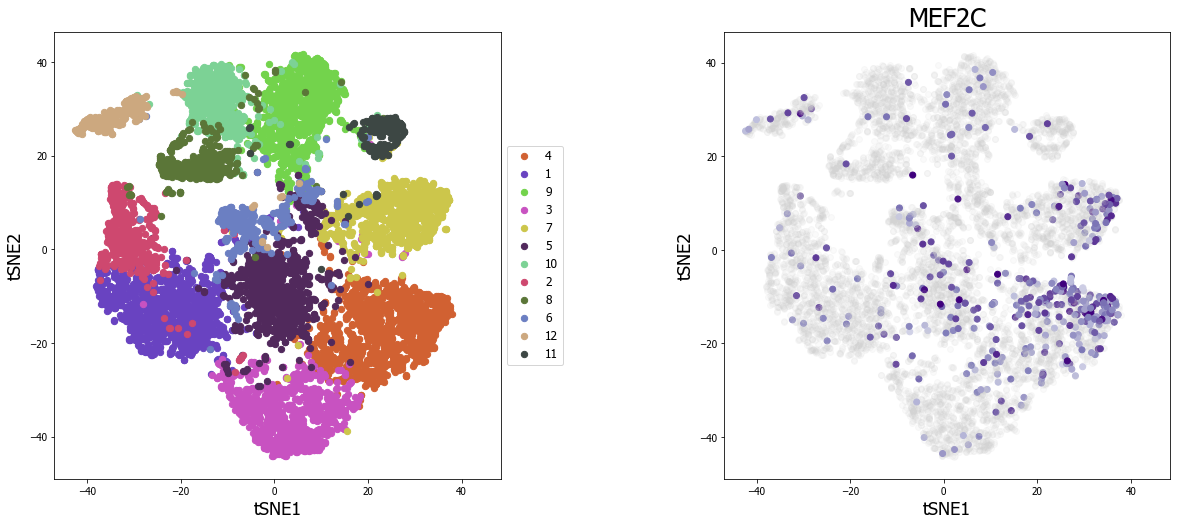

In [58]:
color_list=["#d16132","#6943c1","#73d34c","#c852c1","#ccc64b","#51295c","#7cd295","#ce486f","#5b7638",
            "#6b7fc2","#cca87f","#3d4744","#ca97bd","#793e33","#81bec2"]
fig = plt.figure(figsize=(22,10))
ax=plt.subplot(121)
markersize=40
alpha=1
for j,clust in enumerate(set(df_sbnx_sbn_clust[clust_col])):
    cells = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col] == clust]['Unnamed: 0']
    cells_in_clust = df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells)]
    plt.scatter(cells_in_clust['tSNE_1'],cells_in_clust['tSNE_2'],alpha=alpha,label=cluster_map[clust],color=color_list[j],s=markersize)
plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.axis('square')

ax = plt.subplot(122)
gene='MEF2C'
max_full=0
x1 = [0]
for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx].index:
        x1 = full_df_rpm_logged[tx][tx_cells].loc[gene]
    vmax = max(max_full,max(x1))
colormap = cm.Purples
normalize = Normalize(vmin=0.01, vmax=vmax)

for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx][tx_cells].index:
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]==0
        cells_0_count=x[x==True]
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]>0
        cells_atleast1_count=x[x==True]
        cells_0_count = [tx.lower()+'.'+cell for cell in cells_0_count.index]
        cells_atleast1_count = [tx.lower()+'.'+cell for cell in cells_atleast1_count.index]
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray',alpha=0.1)
        if len(cells_atleast1_count) > 0:
            plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_2'],
                    c=full_df_rpm_logged[tx][[x.split(".")[1] for x in cells_atleast1_count]].loc[gene],cmap=colormap,norm=normalize)

    else:
        cells_0_count=df_sbnx_sbn_tsne['cell']
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray',alpha=0.1)

plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
plt.title(gene,fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axis('square')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/tSNE.MEF2C.pdf')

ok


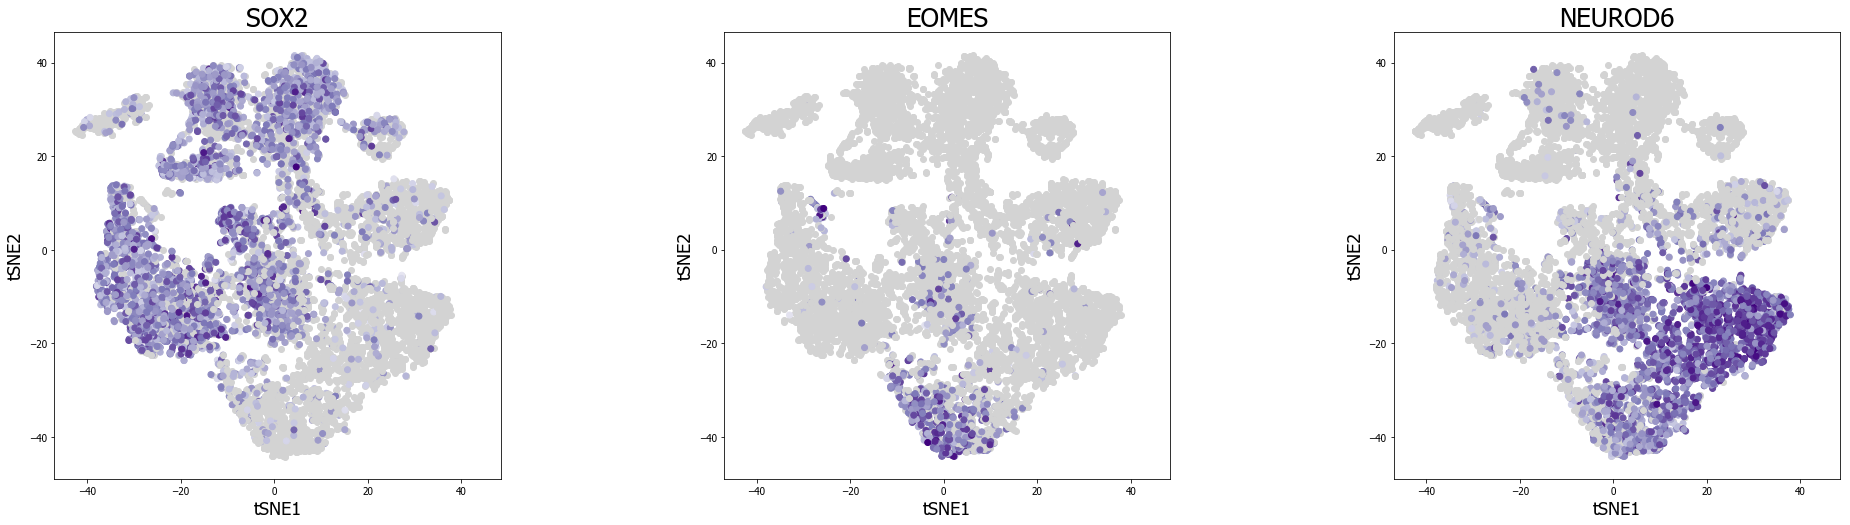

In [52]:
## FIGURE PART 1 -- tsne of clusters

color_list=["#d16132","#6943c1","#73d34c","#c852c1","#ccc64b","#51295c","#7cd295","#ce486f","#5b7638",
            "#6b7fc2","#cca87f","#3d4744","#ca97bd","#793e33","#81bec2"]
fig = plt.figure(figsize=(34,10))

ax=plt.subplot(131)
gene='SOX2'
max_full=0
x1 = [0]
for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx].index:
        x1 = full_df_rpm_logged[tx][tx_cells].loc[gene]
    vmax = max(max_full,max(x1))
colormap = cm.Purples
normalize = Normalize(vmin=0.01, vmax=vmax)

for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx][tx_cells].index:
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]==0
        cells_0_count=x[x==True]
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]>0
        cells_atleast1_count=x[x==True]
        cells_0_count = [tx.lower()+'.'+cell for cell in cells_0_count.index]
        cells_atleast1_count = [tx.lower()+'.'+cell for cell in cells_atleast1_count.index]
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')
        if len(cells_atleast1_count) > 0:
            plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_2'],
                    c=full_df_rpm_logged[tx][[x.split(".")[1] for x in cells_atleast1_count]].loc[gene],cmap=colormap,norm=normalize)

    else:
        cells_0_count=df_sbnx_sbn_tsne['cell']
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')

plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
plt.title(gene,fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axis('square')

## FIGURE PART 2 -- tsne of treatments

ax=plt.subplot(132)
gene='EOMES'
max_full=0
x1 = [0]
for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx].index:
        x1 = full_df_rpm_logged[tx][tx_cells].loc[gene]
    vmax = max(max_full,max(x1))
colormap = cm.Purples
normalize = Normalize(vmin=0.01, vmax=vmax)

for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx][tx_cells].index:
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]==0
        cells_0_count=x[x==True]
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]>0
        cells_atleast1_count=x[x==True]
        cells_0_count = [tx.lower()+'.'+cell for cell in cells_0_count.index]
        cells_atleast1_count = [tx.lower()+'.'+cell for cell in cells_atleast1_count.index]
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')
        if len(cells_atleast1_count) > 0:
            plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_2'],
                    c=full_df_rpm_logged[tx][[x.split(".")[1] for x in cells_atleast1_count]].loc[gene],cmap=colormap,norm=normalize)

    else:
        cells_0_count = [x for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0] == tx.lower()]
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')

plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
plt.title(gene,fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axis('square')

## FIGURE PART 3 -- FOXG1 expression

ax=plt.subplot(133)
gene='NEUROD6'
max_full=0
x1 = [0]
for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx].index:
        x1 = full_df_rpm_logged[tx][tx_cells].loc[gene]
    vmax = max(max_full,max(x1))
colormap = cm.Purples
normalize = Normalize(vmin=0.01, vmax=vmax)

for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx][tx_cells].index:
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]==0
        cells_0_count=x[x==True]
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]>0
        cells_atleast1_count=x[x==True]
        cells_0_count = [tx.lower()+'.'+cell for cell in cells_0_count.index]
        cells_atleast1_count = [tx.lower()+'.'+cell for cell in cells_atleast1_count.index]
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')
        if len(cells_atleast1_count) > 0:
            plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_2'],
                    c=full_df_rpm_logged[tx][[x.split(".")[1] for x in cells_atleast1_count]].loc[gene],cmap=colormap,norm=normalize)

    else:
        cells_0_count=df_sbnx_sbn_tsne['cell']
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')

plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
plt.title(gene,fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axis('square')
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/tsnes.pdf')

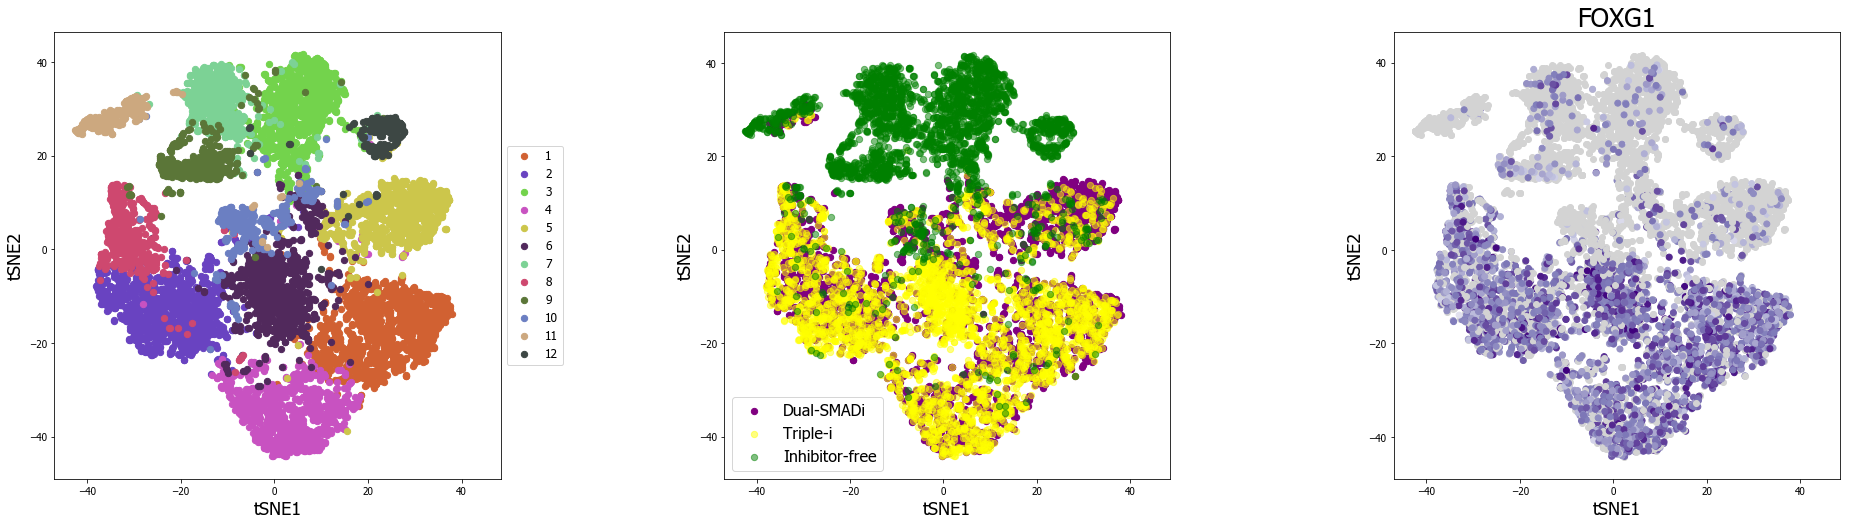

In [12]:
## FIGURE PART 1 -- tsne of clusters

color_list=["#d16132","#6943c1","#73d34c","#c852c1","#ccc64b","#51295c","#7cd295","#ce486f","#5b7638",
            "#6b7fc2","#cca87f","#3d4744","#ca97bd","#793e33","#81bec2"]
fig = plt.figure(figsize=(34,10))
ax=plt.subplot(131)
markersize=40
alpha=1
for j,clust in enumerate(set(df_sbnx_sbn_clust[clust_col])):
    cells = df_sbnx_sbn_clust[df_sbnx_sbn_clust[clust_col] == clust]['Unnamed: 0']
    cells_in_clust = df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells)]
    plt.scatter(cells_in_clust['tSNE_1'],cells_in_clust['tSNE_2'],alpha=alpha,label=clust+1,color=color_list[j],s=markersize)
plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.axis('square')

## FIGURE PART 2 -- tsne of treatments

ax=plt.subplot(132)
markersize=40
alpha=0.5
plt.scatter(df_sbnx_sbn_tsne[(df_sbnx_sbn_tsne['cell'].str.contains('sbnx')==False) & 
                            (df_sbnx_sbn_tsne['cell'].str.contains('nt')==False)]['tSNE_1'],
            df_sbnx_sbn_tsne[(df_sbnx_sbn_tsne['cell'].str.contains('sbnx')==False) & 
                            (df_sbnx_sbn_tsne['cell'].str.contains('nt')==False)]['tSNE_2'],
            color=sbn_color,alpha=1.0,label='Dual-SMADi',s=markersize)
plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].str.contains('sbnx')]['tSNE_1'],
            df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].str.contains('sbnx')]['tSNE_2'],
            color=sbnx_color,alpha=alpha,label='Triple-i',s=markersize)
plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].str.contains('nt')]['tSNE_1'],
            df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].str.contains('nt')]['tSNE_2'],
            color=nt_color,alpha=alpha,label='Inhibitor-free',s=markersize)
plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)
plt.legend(fontsize=16)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/tsne.pdf')
plt.axis('square')

## FIGURE PART 3 -- FOXG1 expression

ax=plt.subplot(133)
gene='FOXG1'
max_full=0
for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx].index:
        x1 = full_df_rpm_logged[tx][tx_cells].loc[gene]
    else:
        x1 = [0]
    vmax = max(max_full,max(x1))
colormap = cm.Purples
normalize = Normalize(vmin=0.01, vmax=vmax)

for tx in ['SBNx','SBN','NT']:
    tx_cells = [x.split(".")[1] for x in df_sbnx_sbn_tsne['cell'] if x.split(".")[0]==tx.lower()]
    if gene in full_df_rpm_logged[tx][tx_cells].index:
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]==0
        cells_0_count=x[x==True]
        x=full_df_rpm_logged[tx][tx_cells].loc[gene]>0
        cells_atleast1_count=x[x==True]
        cells_0_count = [tx.lower()+'.'+cell for cell in cells_0_count.index]
        cells_atleast1_count = [tx.lower()+'.'+cell for cell in cells_atleast1_count.index]
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_atleast1_count)]['tSNE_2'],
                    c=full_df_rpm_logged[tx][[x.split(".")[1] for x in cells_atleast1_count]].loc[gene],cmap=colormap,norm=normalize)

    else:
        cells_0_count=df_sbnx_sbn_tsne['cell']
        plt.scatter(df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_1'],
                    df_sbnx_sbn_tsne[df_sbnx_sbn_tsne['cell'].isin(cells_0_count)]['tSNE_2'],color='lightgray')

plt.xlabel('tSNE1',fontsize=18)
plt.ylabel('tSNE2',fontsize=18)
plt.title(gene,fontsize=26)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.axis('square')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/tsnes.pdf')

In [31]:
tmp_reg = copy.deepcopy(reg_and_temp_genes['Brain Regions Genes'])
#tmp_reg.insert(16,('MEF2C','Neocortex'))
tmp_reg
for gene in ['MKI67','TOP2A','HMGB2']:
    tmp_reg.append((gene,'Cycling Genes'))
for gene in ['DCX','STMN2','NELL2']:
    tmp_reg.append((gene,'Early Neurons'))
for gene in ['DCN','LUM','COL1A2']:
    tmp_reg.append((gene,'Mesoderm'))

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


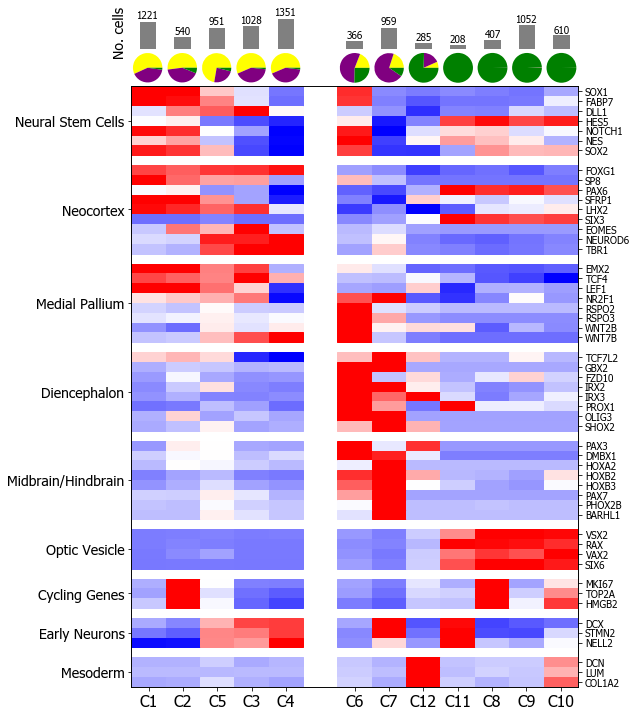

In [32]:
ordered_clusters = range(len(set(df_sbnx_sbn_clust[clust_col])))
ordered_clusters = [1,7,5,3,0,9,4,10,11,8,2,6]#[0,10,5,3,1,7,4,9,2,6,8,11]#[1,7,5,2,0,9,10,4,3,6,8,11]
fig = plt.figure(figsize=(8,13))
breaks=[4]
gs = gridspec.GridSpec(20,len(ordered_clusters)+len(breaks),wspace=0.05, hspace=0.05)
y_start,y_end=2,3
ax = plt.subplot(gs[y_end:,:])
fig = make_heatmap_zscore(fig,ax,tmp_reg,#reg_and_temp_genes['Brain Regions Genes'],
                   cluster_counts_rpm_logged,ordered_clusters,df_sbnx_sbn_clust,clust_col=clust_col,breaks=breaks,
                         labs = ['C'+str(x) for x in [1,2,5,3,4,6,7,12,11,8,9,10]])
fig = add_picharts(fig,y_start,y_end,ordered_clusters,n_cells_per_clust,color_dict,breaks=breaks)
y_start,y_end=1,2
fig = add_bars(fig,y_start,y_end,ordered_clusters,n_cells_per_clust,color_dict,breaks=breaks)
plt.gcf()
plt.tight_layout()
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/heatmap.zscores.w_MEF2C.pdf')
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/heatmap.zscores.pdf')

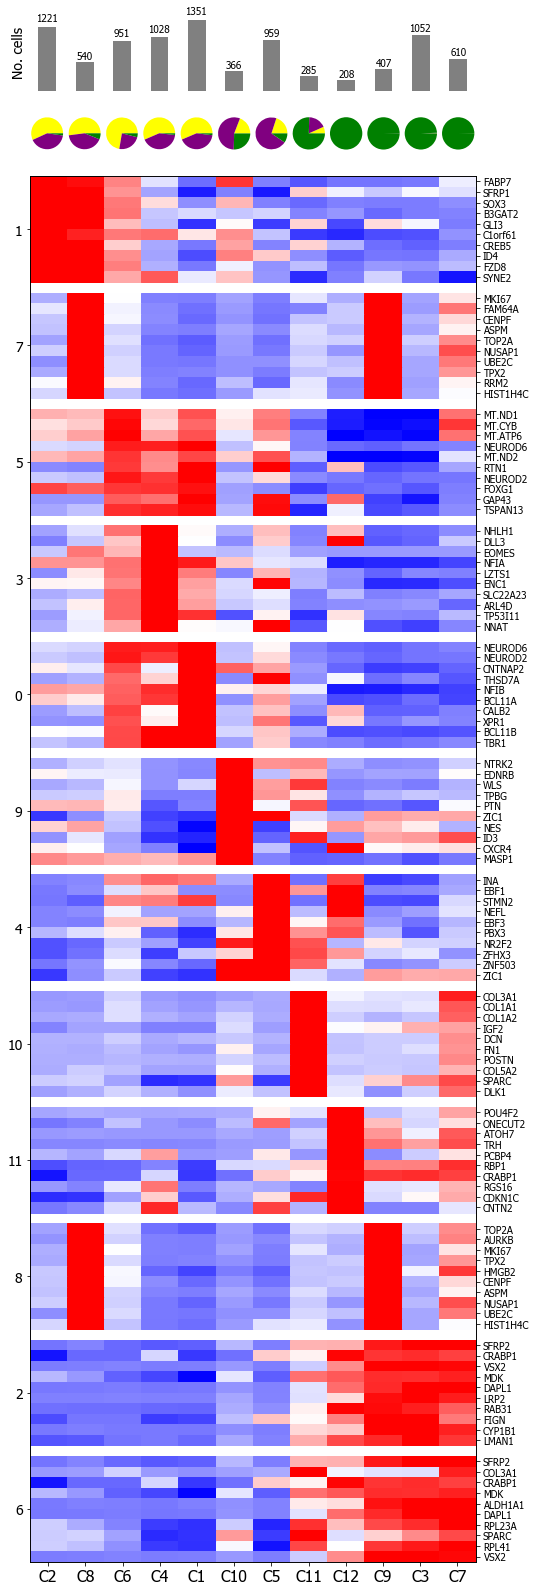

In [17]:
markers_per_clust = {}
for row in df_markers.iterrows():
    clust = int(row[1][6])
    if clust not in markers_per_clust: markers_per_clust[clust] = []
    markers_per_clust[clust].append(row[1][7])
    
#ordered_clusters = range(len(set(df_sbnx_sbn_clust[clust_col])))
#ordered_clusters = [1,7,5,2,0,9,12,10,4,3,6,8,11]
ordered_marker_genes = []
for clust in ordered_clusters:
    for gene in markers_per_clust[clust]:
        ordered_marker_genes.append((gene,clust))
fig = plt.figure(figsize=(8,30))
gs = gridspec.GridSpec(20,len(ordered_clusters),wspace=0.05, hspace=0.05)
y_start,y_end=2,3
ax = plt.subplot(gs[y_end:,:])
fig = make_heatmap_zscore(fig,ax,ordered_marker_genes,
                   cluster_counts_rpm_logged,ordered_clusters,df_sbnx_sbn_clust,clust_col=clust_col)
fig = add_picharts(fig,y_start,y_end,ordered_clusters,n_cells_per_clust,color_dict)
y_start,y_end=1,2
fig = add_bars(fig,y_start,y_end,ordered_clusters,n_cells_per_clust,color_dict)
#plt.gcf()
#plt.tight_layout()
#plt.show()
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/heatmap.zscores.marker_genes.pdf')

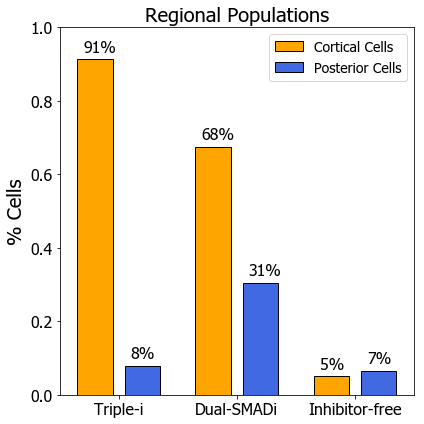

In [34]:
cortical_clusters = []
non_cortical_clusters = []
for j,clust in enumerate(ordered_clusters):
    if cluster_counts_rpm_logged[clust].loc['FOXG1'] > 1:
        cortical_clusters.append(clust)
    else:
        non_cortical_clusters.append(clust)

posterior_clusters = [9,4]
cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
posterior_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in posterior_clusters:
    for tx in ['sbn','sbnx','nt']:
        posterior_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
        
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for j,tx in enumerate(['sbnx','sbn','nt']):
    plt.bar(j,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),width=0.3,color='orange',edgecolor='black')
    plt.bar(j+0.4,float(len(posterior_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),width=0.3,color='royalblue',edgecolor='black')
    plt.annotate(str(int(round(float(100*len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])))))+'%',
                 xy=(j-0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
    plt.annotate(str(int(round(float(100*len(posterior_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])))))+'%',
                 xy=(j-0.1+0.4,float(len(posterior_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.xticks([x+0.2 for x in range(j+1)],['Triple-i','Dual-SMADi','Inhibitor-free'],fontsize=16)
plt.ylim(0,1)
plt.ylabel('% Cells',fontsize=20)
plt.title('Regional Populations',fontsize=20)
plt.yticks(fontsize=16)

plt.xlim(-0.3,2.7)

plt.bar(-5,-5,color='orange',edgecolor='black',label='Cortical Cells')
plt.bar(-5,-5,color='royalblue',edgecolor='black',label='Posterior Cells')
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/cortical_populations.barplot.pdf')

sbnx 0.0667302192564
sbn 0.217344753747
nt 0.0384138785626


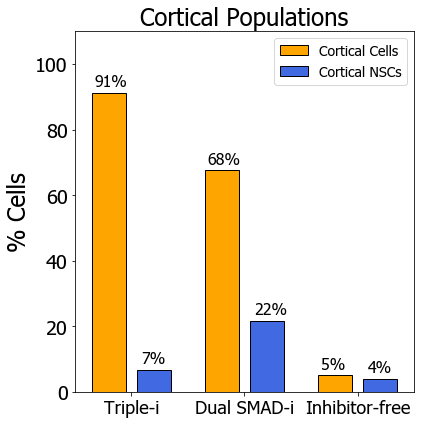

In [51]:
cortical_clusters = []
non_cortical_clusters = []
for j,clust in enumerate(ordered_clusters):
    if cluster_counts_rpm_logged[clust].loc['FOXG1'] > 1:
        cortical_clusters.append(clust)
    else:
        non_cortical_clusters.append(clust)

cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
        
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for j,tx in enumerate(['sbnx','sbn','nt']):
    #plt.bar(2*j+0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color=color_dict[tx],width=0.6)
    plt.bar(2*j+0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color='orange',width=0.6,edgecolor='black')
    plt.annotate(str(int(round(float(100*len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])))))+'%',
                 xy=(2*j+0.1-0.25,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.title('Cortical Populations',fontsize=24)
plt.yticks(fontsize=20)


cortical_clusters = [9]
non_cortical_clusters = [1,7,8,2,6,11]

cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])


for j,tx in enumerate(['sbnx','sbn','nt']):
    print tx, float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))
    #plt.bar(2*j+0.9,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color=color_dict[tx],width=0.6)#,edgecolor='black')
    plt.bar(2*j+0.9,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color='royalblue',width=0.6,edgecolor='black')
    plt.annotate(#"N="+str((len(cortical_cells[tx])+len(noncortical_cells[tx])))+"\n  "+
                 str(int(round(float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))*100)))+'%',
                 xy=(2*j+0.8-0.125,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.xticks([.5,2.5,4.5],['Triple-i','Dual SMAD-i','Inhibitor-free'],fontsize=18)
plt.ylabel('% Cells',fontsize=24)
#plt.title('Cortical Stem Cell \n Population per NSC population \n per protocol',fontsize=30)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,20,40,60,80,100],fontsize=20)
plt.ylim(0,1.1)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/cortical_stem_cell_populations_per_nsc_population_per_protocol.barplot.pdf')
plt.xlim(-0.5,5.5)

plt.bar(-5,-5,color='orange',edgecolor='black',label='Cortical Cells')
plt.bar(-5,-5,color='royalblue',edgecolor='black',label='Cortical NSCs')
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/cortical_populations.barplot.v2.pdf')

sbnx 0.929456625357
sbn 0.777301927195
nt 0.0247831474597


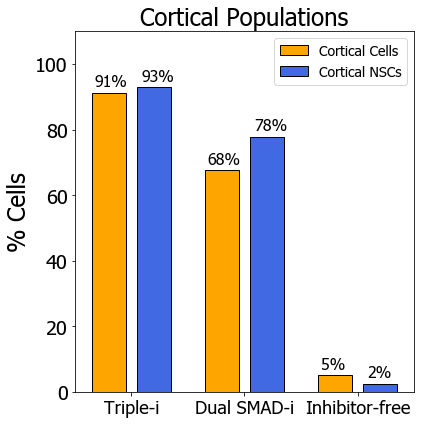

In [54]:
cortical_clusters = []
non_cortical_clusters = []
for j,clust in enumerate(ordered_clusters):
    if cluster_counts_rpm_logged[clust].loc['FOXG1'] > 1:
        cortical_clusters.append(clust)
    else:
        non_cortical_clusters.append(clust)

cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
        
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for j,tx in enumerate(['sbnx','sbn','nt']):
    #plt.bar(2*j+0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color=color_dict[tx],width=0.6)
    plt.bar(2*j+0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color='orange',width=0.6,edgecolor='black')
    plt.annotate(str(int(round(float(100*len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])))))+'%',
                 xy=(2*j+0.1-0.25,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.title('Cortical Populations',fontsize=24)
plt.yticks(fontsize=20)


cortical_clusters = [1,7]
non_cortical_clusters = [9,8,2,6,11]

cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])


for j,tx in enumerate(['sbnx','sbn','nt']):
    print tx, float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))
    #plt.bar(2*j+0.9,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color=color_dict[tx],width=0.6)#,edgecolor='black')
    plt.bar(2*j+0.9,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color='royalblue',width=0.6,edgecolor='black')
    plt.annotate(#"N="+str((len(cortical_cells[tx])+len(noncortical_cells[tx])))+"\n  "+
                 str(int(round(float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))*100)))+'%',
                 xy=(2*j+0.8-0.125,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.xticks([.5,2.5,4.5],['Triple-i','Dual SMAD-i','Inhibitor-free'],fontsize=18)
plt.ylabel('% Cells',fontsize=24)
#plt.title('Cortical Stem Cell \n Population per NSC population \n per protocol',fontsize=30)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,20,40,60,80,100],fontsize=20)
plt.ylim(0,1.1)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/cortical_stem_cell_populations_per_nsc_population_per_protocol.barplot.pdf')
plt.xlim(-0.5,5.5)

plt.bar(-5,-5,color='orange',edgecolor='black',label='Cortical Cells')
plt.bar(-5,-5,color='royalblue',edgecolor='black',label='Cortical NSCs')
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/cortical_populations.barplot.v2.pdf')

sbnx 0.0667302192564
sbn 0.217344753747
nt 0.0384138785626


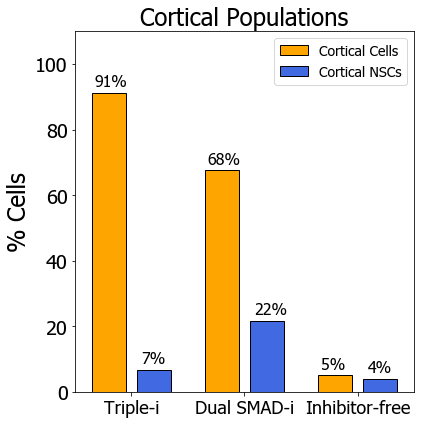

In [53]:
cortical_clusters = []
non_cortical_clusters = []
for j,clust in enumerate(ordered_clusters):
    if cluster_counts_rpm_logged[clust].loc['FOXG1'] > 1:
        cortical_clusters.append(clust)
    else:
        non_cortical_clusters.append(clust)

cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
        
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for j,tx in enumerate(['sbnx','sbn','nt']):
    #plt.bar(2*j+0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color=color_dict[tx],width=0.6)
    plt.bar(2*j+0.1,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color='orange',width=0.6,edgecolor='black')
    plt.annotate(str(int(round(float(100*len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])))))+'%',
                 xy=(2*j+0.1-0.25,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.title('Cortical Populations',fontsize=24)
plt.yticks(fontsize=20)


cortical_clusters = [9]
non_cortical_clusters = [1,7,8,2,6,11]

cortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
noncortical_cells = {'sbn':[],'sbnx':[],'nt':[]}
for clust in cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        cortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])
for clust in non_cortical_clusters:
    for tx in ['sbn','sbnx','nt']:
        noncortical_cells[tx].extend([x for x in cells_per_clust[clust] if x.split(".")[0] == tx])


for j,tx in enumerate(['sbnx','sbn','nt']):
    print tx, float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))
    #plt.bar(2*j+0.9,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color=color_dict[tx],width=0.6)#,edgecolor='black')
    plt.bar(2*j+0.9,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx])),color='royalblue',width=0.6,edgecolor='black')
    plt.annotate(#"N="+str((len(cortical_cells[tx])+len(noncortical_cells[tx])))+"\n  "+
                 str(int(round(float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))*100)))+'%',
                 xy=(2*j+0.8-0.125,float(len(cortical_cells[tx]))/(len(cortical_cells[tx])+len(noncortical_cells[tx]))+0.02),fontsize=16)
plt.xticks([.5,2.5,4.5],['Triple-i','Dual SMAD-i','Inhibitor-free'],fontsize=18)
plt.ylabel('% Cells',fontsize=24)
#plt.title('Cortical Stem Cell \n Population per NSC population \n per protocol',fontsize=30)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,20,40,60,80,100],fontsize=20)
plt.ylim(0,1.1)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/cortical_stem_cell_populations_per_nsc_population_per_protocol.barplot.pdf')
plt.xlim(-0.5,5.5)

plt.bar(-5,-5,color='orange',edgecolor='black',label='Cortical Cells')
plt.bar(-5,-5,color='royalblue',edgecolor='black',label='Cortical NSCs')
plt.legend(fontsize=14)
plt.tight_layout()

#plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/cortical_populations.barplot.v2.pdf')

FOXG1
EMX2
SP8


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


GBX2
PAX6
OTX2
VSX2
DCN


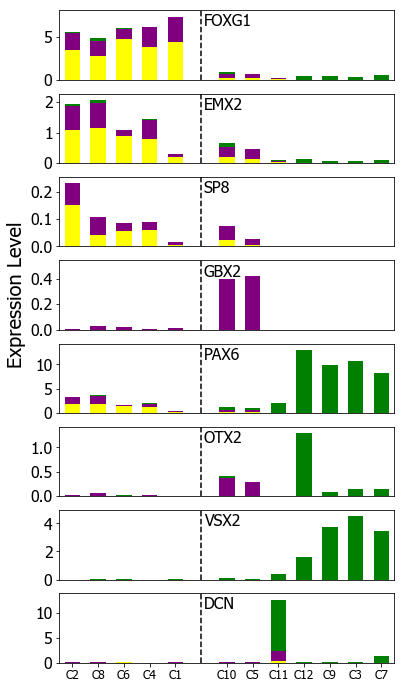

In [35]:
ordered_clusters = [1,7,5,3,0,9,4,10,11,8,2,6]

ylab_fs=20
xlab_fs=12
title_fs=20
fig = plt.figure(figsize=(6,12))

breaks = [4]
gene_list=['FOXG1','EMX2','SP8','GBX2','PAX6','OTX2','VSX2','DCN']

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
    else:
        plt.xticks([])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    if ii == 3:
        plt.ylabel('Expression Level',fontsize=ylab_fs)
    plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    if gene == 'GBX2':
        plt.ylim(0,1.3*ymax)
    plt.title('')
    if gene == 'GBX2':
        plt.annotate(gene,xy=(breaks[0]+1.1,ymax),fontsize=16)
    else:
        plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/regional_genes.barplots.v2.pdf')
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Figures/single_cell_figure/regional_genes.barplots.pdf')

In [43]:
ordered_clusters

[1, 7, 5, 3, 0, 9, 4, 10, 11, 8, 2, 6]

PALLD
DACH1
SALL1


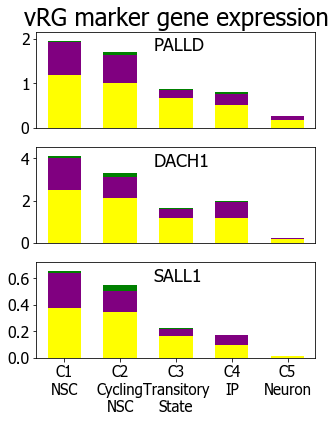

In [64]:
ylab_fs=20
xlab_fs=15
title_fs=20
fig = plt.figure(figsize=(5,6))

breaks = []#[4]
gene_list=['PALLD','DACH1','SALL1']

ordered_clusters = [1, 7, 5, 3, 0]

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x)+'\n'+y for x,y in zip([1,2,3,4,5],['NSC','Cycling\nNSC','Transitory\nState','IP','Neuron'])],fontsize=xlab_fs)
    else:
        plt.xticks([])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    #if ii == 3:
    #    plt.ylabel('Expression Level',fontsize=ylab_fs)
    #plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    plt.annotate(gene,xy=(1.6,ymax-0.12*ymax),fontsize=18)
    #if gene == 'SOX2':
    #    plt.ylim(0,1.2*ymax)
    if ii == 0:
        plt.title('vRG marker gene expression',fontsize=24)
    #plt.ylabel(gene)
    #if gene == 'SOX2':
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.05*ymax),fontsize=16)
    #else:
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/v2/vRG_genes.pdf')

LIFR
HOPX
RTN1


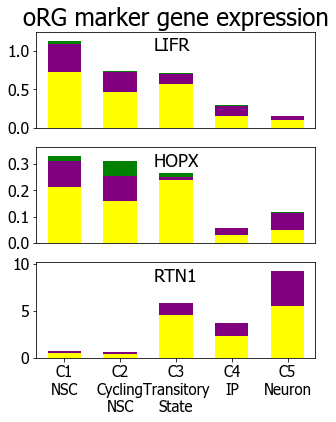

In [62]:
ylab_fs=20
xlab_fs=15
title_fs=20
fig = plt.figure(figsize=(5,6))

breaks = []#[4]
gene_list=['LIFR','HOPX','RTN1']

ordered_clusters = [1, 7, 5, 3, 0]

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x)+'\n'+y for x,y in zip([1,2,3,4,5],['NSC','Cycling\nNSC','Transitory\nState','IP','Neuron'])],fontsize=xlab_fs)
        #plt.xticks(xticks,['NSC','Cycling\nNSC','Transitory\nState','IP','Neuron'],fontsize=14)#+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
    else:
        plt.xticks([])
    if gene == 'LIFR':
        plt.yticks([0,0.5,1])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    #if ii == 3:
    #    plt.ylabel('Expression Level',fontsize=ylab_fs)
    #plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    plt.annotate(gene,xy=(1.6,ymax-0.12*ymax),fontsize=18)
    #if gene == 'SOX2':
    #    plt.ylim(0,1.2*ymax)
    if ii == 0:
        plt.title('oRG marker gene expression',fontsize=24)
    #plt.ylabel(gene)
    #if gene == 'SOX2':
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.05*ymax),fontsize=16)
    #else:
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/v2/oRG_genes.pdf')

PTPRZ1
HOPX


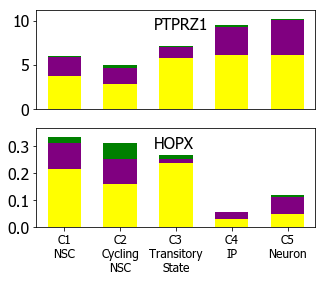

In [63]:
ylab_fs=20
xlab_fs=12
title_fs=20
fig = plt.figure(figsize=(5,4))

breaks = []#[4]
gene_list=['PTPRZ1','HOPX']

ordered_clusters = [1, 7, 5, 3, 0]

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x)+'\n'+y for x,y in zip([1,2,3,4,5],['NSC','Cycling\nNSC','Transitory\nState','IP','Neuron'])],fontsize=xlab_fs)
    else:
        plt.xticks([])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    #if ii == 3:
    #    plt.ylabel('Expression Level',fontsize=ylab_fs)
    plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    plt.annotate(gene,xy=(1.6,ymax-0.12*ymax),fontsize=16)
    #if gene == 'SOX2':
    #    plt.ylim(0,1.2*ymax)
    plt.title('')
    #plt.ylabel(gene)
    #if gene == 'SOX2':
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.05*ymax),fontsize=16)
    #else:
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/oRG_genes.1.pdf')

LIFR
TNC


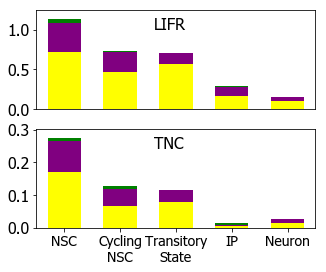

In [81]:
ylab_fs=20
xlab_fs=12
title_fs=20
fig = plt.figure(figsize=(5,4))

breaks = []#[4]
gene_list=['LIFR','TNC']

ordered_clusters = [1, 7, 5, 3, 0]

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
        plt.xticks(xticks,['NSC','Cycling\nNSC','Transitory\nState','IP','Neuron'],fontsize=14)#+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
    else:
        plt.xticks([])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    #if ii == 3:
    #    plt.ylabel('Expression Level',fontsize=ylab_fs)
    plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    plt.annotate(gene,xy=(1.6,ymax-0.12*ymax),fontsize=16)
    #if gene == 'SOX2':
    #    plt.ylim(0,1.2*ymax)
    plt.title('')
    #plt.ylabel(gene)
    #if gene == 'SOX2':
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.05*ymax),fontsize=16)
    #else:
    #    plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/OSVZ_figure/oRG_genes.2.pdf')

FOXG1
EMX2
SP8


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


PAX6
VSX2
OTX2


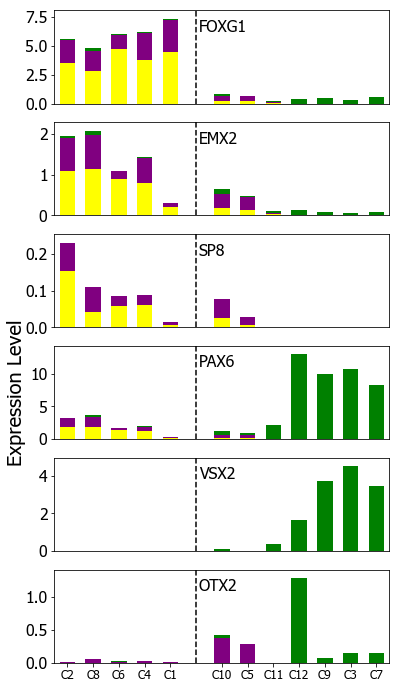

In [46]:
ylab_fs=20
xlab_fs=12
title_fs=20
fig = plt.figure(figsize=(6,12))

breaks = [4]
gene_list=['FOXG1','EMX2','SP8','PAX6','VSX2','OTX2']

ordered_clusters = [1, 7, 5, 3, 0, 9, 4, 10, 11, 8, 2, 6]

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
    else:
        plt.xticks([])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    if ii == 3:
        plt.ylabel('Expression Level',fontsize=ylab_fs)
    plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    if gene == 'SOX2':
        plt.ylim(0,1.2*ymax)
    plt.title('')
    if gene == 'SOX2':
        plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.05*ymax),fontsize=16)
    else:
        plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/cell_type_genes.barplots.v2.pdf')

FOXG1
EMX2
SP8


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


PAX6
VSX2
OTX2
GBX2


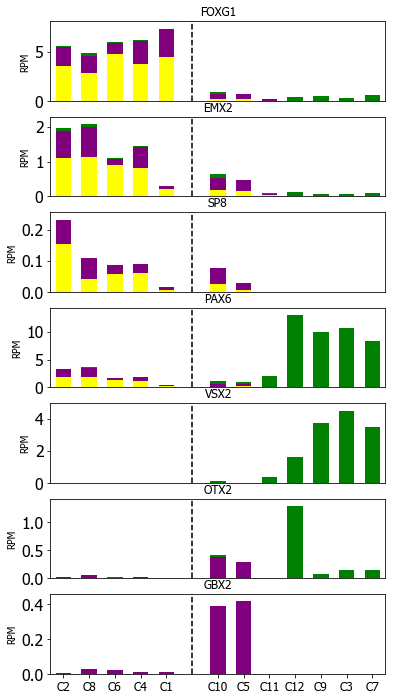

In [44]:
ylab_fs=10
xlab_fs=12
title_fs=20
fig = plt.figure(figsize=(6,12))

breaks = [4]
gene_list=['FOXG1','EMX2','SP8','PAX6','VSX2','OTX2','GBX2']

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
    else:
        plt.xticks([])
    plt.ylabel('RPM',fontsize=ylab_fs)
    plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)

SOX2
SOX1
HES5
EOMES
NEUROD6
TBR1


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


DCX
MKI67


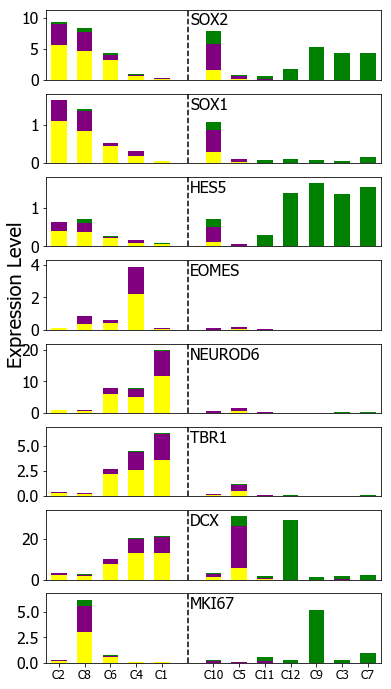

In [36]:
ylab_fs=20
xlab_fs=12
title_fs=20
fig = plt.figure(figsize=(6,12))

breaks = [4]
gene_list=['SOX2','SOX1','HES5','EOMES','NEUROD6','TBR1','DCX','MKI67']

for ii,gene in enumerate(gene_list):
    
    ymax=0
    print gene
    plt.subplot(len(gene_list),1,ii+1)
    xbuff=0
    xticks = []
    for j,clust in enumerate(ordered_clusters):
        try:
            full_rpm = cluster_counts_rpm[clust].loc[gene]
        except:
            full_rpm = 0
        if full_rpm > ymax: ymax = full_rpm
        try:
            full_counts = cluster_counts[clust].loc[gene]
        except:
            full_counts = cluster_counts[clust].loc['FOXG1']
        prev_percent = 0
        xticks.append(j+xbuff)
        for i,tx in enumerate(['sbnx','sbn','nt']):
            try:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc[gene]
            except:
                tx_counts = cluster_counts_sep[tx+'.'+str(clust)].loc['FOXG1']
            percent = tx_counts/full_counts
            plt.bar(j+xbuff,percent*full_rpm,bottom=prev_percent*full_rpm,color=color_dict[tx],width=0.6)
            prev_percent+=percent
        if j in breaks:
            xbuff+=1
            plt.axvline(j+xbuff,color='black',linestyle='--')
    if ii == len(gene_list)-1:
        plt.xticks(xticks,['C'+str(x+1) for x in ordered_clusters],fontsize=xlab_fs)
    else:
        plt.xticks([])
    #plt.ylabel('RPM',fontsize=ylab_fs)
    if ii == 3:
        plt.ylabel('Expression Level',fontsize=ylab_fs)
    plt.title(gene,fontsize=12)
    plt.xlim(-0.5,len(ordered_clusters)+xbuff-0.5)
    plt.yticks(fontsize=16)
    plt.ylim(0,1.1*ymax)
    if gene == 'SOX2':
        plt.ylim(0,1.2*ymax)
    plt.title('')
    if gene == 'SOX2':
        plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.05*ymax),fontsize=16)
    else:
        plt.annotate(gene,xy=(breaks[0]+1.1,ymax-0.15*ymax),fontsize=16)
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/single_cell_figure/cell_type_genes.barplots.v2.pdf')